# Chicago Divvy Bicycle Sharing Data

#### Features description:
<br><b>trip_idID</b> attached to each trip taken
<br><b>year</b>
<br><b>month</b>
<br><b>week</b> week No.
<br><b>day</b> 
<br><b>hour</b> 
<br><b>usertype</b> "Customer" is a rider who purchased a 24-Hour Pass; "Subscriber" is a rider who purchased an Annual Membership
<br><b>gender</b>
<br><b>starttimeday</b> and time trip started, in CST
<br><b>stoptimeday</b> and time trip ended, in CST
<br><b>tripdurationtime</b> of trip in minutes
<br><b>temperature</b>
<br><b>events</b>
<br><b>from_station_idID</b> of station where trip originated
<br><b>from_station_namename</b> of station where trip terminated
<br><b>latitude_startstation</b> latitude
<br><b>longitude_startstation</b> longitude
<br><b>dpcapacity_startnumber</b> of total docks at each station
<br><b>to_station_id</b>
<br><b>to_station_name</b>
<br><b>latitude_end</b>
<br><b>longitude_end</b>
<br><b>dpcapacity_endnumber</b> of total docks at each station

## 1. Importing Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')

## 2. Loading

In [2]:
path = "../input/data.csv"
df = pd.read_csv(path)

## 3. Data preprocessing and Inspecting Data

### Chigaco holidays, federal and locals from 2014 to 2017

New Year’s Day January 1,
Christmas Day December 25,
Veteran’s Day November 11,
Independence Day July 4,
Martin Luther King Jr Day Third Monday in January,
President’s Day Third Monday in February,
Pulaski Day First Monday in March (observed mostly by city offices),
Memorial Day Last Monday in May,
Labor Day First Monday in September,
Columbus Day Second Monday in October and
Thanksgiving Day Fourth Thursday in November

In [3]:
holidays = [
'2014-01-01','2014-12-25',
'2014-11-11','2014-07-04',
'2014-01-20','2014-02-17',
'2014-03-02','2014-05-26',
'2014-09-01','2014-10-13',
'2014-11-27','2015-01-01',
'2015-12-25','2015-11-11',
'2015-07-04','2015-01-19',
'2015-02-16','2015-03-02',
'2015-05-25','2015-09-07',
'2015-10-12','2015-11-26',
'2016-01-01','2016-12-25',
'2016-11-11','2016-07-04',
'2016-01-18','2016-02-15',
'2016-03-04','2016-05-30',
'2016-09-05','2016-10-10',
'2016-11-24','2017-01-01',
'2017-12-25','2017-11-11',
'2017-07-04','2017-01-16',
'2017-02-20','2017-03-06',
'2017-05-29','2017-09-04',
'2017-10-09','2017-11-23'
]

df_holidays = pd.DataFrame(holidays)
df_holidays['date'] = pd.to_datetime(df_holidays[0]).dt.date
df_holidays['holiday'] = 1
df_holidays = df_holidays.drop([0], axis=1)

In [4]:
#Include '0' in dr.day
df.day =  df.starttime.astype(str).str.slice(8,10).astype(int)

### New Features

In [5]:
#Starttime e Stoptime para data
df.starttime = pd.to_datetime(df.starttime)
df.stoptime  = pd.to_datetime(df.stoptime)
df['date']   = df.starttime.dt.date

#Definição fim de semana
df['weekend'] = np.where(df.starttime.dt.weekday > 4 , 1, 0)

#Inicializando novas features
df['season'] = ''

#Definição estações Hemisfério NORTE
for x in range(df.year.min().astype(int)-1, df.year.max().astype(int)+1):
    #Primavera: 21-03 até 20-06
    df.loc[(df.starttime >= str(x)+'-03-21 00:00:00') & (df.starttime <= str(x)+'-06-20 23:59:59'),  'season'] = 'primavera'
    #Verão:     21-06 até 20-09
    df.loc[(df.starttime >= str(x)+'-06-21 00:00:00') & (df.starttime <= str(x)+'-09-20 23:59:59'),  'season'] = 'verão'
    #Outono:    21-09 até 20-12
    df.loc[(df.starttime >= str(x)+'-09-21 00:00:00') & (df.starttime <= str(x)+'-12-20 23:59:59'),  'season'] = 'outono'
    #Inverno:   21-12 até 20-03
    df.loc[(df.starttime >= str(x)+'-12-21 00:00:00') & (df.starttime <= str(x+1)+'-03-20 23:59:59'),'season'] = 'inverno'

### Join - dataset and hollydays

In [6]:
df_holidays.head()
df_join = df.set_index('date').join(df_holidays.set_index('date'))
df_join['isholiday']  = np.where(df_join.holiday==1, 1, 0)
df_join['regularday'] = np.where(df_join.isholiday+df_join.weekend == 0, 1, 0)

In [7]:
#clear DF
df.iloc[0:0]
del df

In [8]:
#Features
print(list(df_join))

['trip_id', 'year', 'month', 'week', 'day', 'hour', 'usertype', 'gender', 'starttime', 'stoptime', 'tripduration', 'temperature', 'events', 'from_station_id', 'from_station_name', 'latitude_start', 'longitude_start', 'dpcapacity_start', 'to_station_id', 'to_station_name', 'latitude_end', 'longitude_end', 'dpcapacity_end', 'weekend', 'season', 'holiday', 'isholiday', 'regularday']


In [9]:
#Data frame aggregation
dfagg = df_join
df_map = df_join

#Trip count
dfagg['trip_count'] = 1

#Features
col = ['date', 'year', 'month','day', 'hour','usertype', 'gender', 'events', 'weekend','isholiday', 'regularday', 'season']

#aggregation
dfagg =  dfagg.groupby(col).aggregate({  'temperature'     : 'mean',
                                         'tripduration'    : 'mean',
                                         'trip_count'      : 'sum',
                                         'dpcapacity_start': 'mean',
                                         'dpcapacity_end'  : 'mean'
                                        }).reset_index()

df_map =  df_map.groupby(['latitude_start','longitude_start']).aggregate({
                                         'trip_count'      : 'sum',
                                         'tripduration'    : 'mean'}).reset_index()

In [10]:
#clear DF_JOIN
df_join.iloc[0:0]
del df_join

## 4. Analysis

### 4.1 Analyze the differences between weeks, weekends and holidays

In [11]:
dfagg.head(5)
dfagg_day = dfagg
conditions = [(dfagg_day['weekend'] == 1) ,
              (dfagg_day['isholiday'] == 1),
              (dfagg_day['regularday'] == 1)]

choices = ['WEEKEND', 'HOLIDAY',  'REGULAR']
dfagg_day['DayType'] = np.select(conditions, choices)
dfagg_day['CounDays'] = 1




#Weekend
dfagg_hour_week = dfagg_day[dfagg_day.DayType=='WEEKEND']
dfagg_hour_week =  dfagg_hour_week.groupby(['date', 'hour']).aggregate({                                           
                                         'trip_count'      : 'sum'                                                                                  
                                        }).reset_index()
dfagg_hour_week =  dfagg_hour_week.groupby(['hour']).aggregate({                                           
                                         'trip_count'      : 'mean'                                                                                  
                                        }).reset_index()

#Workday
dfagg_hour_reg = dfagg_day[dfagg_day.DayType=='REGULAR']
dfagg_hour_reg = dfagg_hour_reg.groupby(['date', 'hour']).aggregate({                                           
                                         'trip_count'      : 'sum'                                                                                  
                                        }).reset_index()
dfagg_hour_reg = dfagg_hour_reg.groupby(['hour']).aggregate({                                           
                                         'trip_count'      : 'mean'                                                                                  
                                        }).reset_index()

#holiday
dfagg_hour_hol = dfagg_day[dfagg_day.DayType=='HOLIDAY']
dfagg_hour_hol = dfagg_hour_hol.groupby(['date', 'hour']).aggregate({                                           
                                         'trip_count'      : 'sum'                                                                                  
                                        }).reset_index()
dfagg_hour_hol = dfagg_hour_hol.groupby(['hour']).aggregate({                                           
                                         'trip_count'      : 'mean'                                                                                  
                                        }).reset_index()

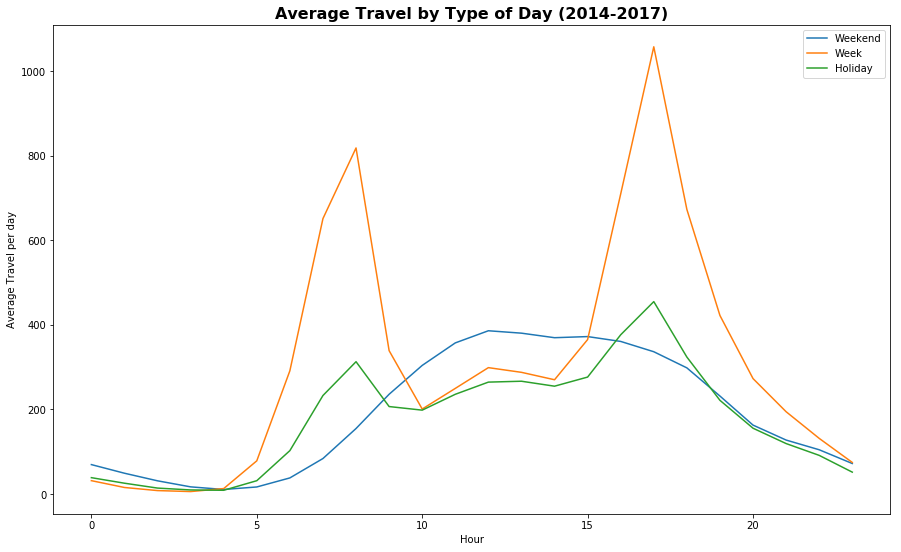

In [12]:
#plot average travel chart
plt.rcParams["figure.figsize"] = (15,9)



plt.plot(dfagg_hour_week.hour, dfagg_hour_week.trip_count, label="Weekend")
plt.plot(dfagg_hour_reg.hour, dfagg_hour_reg.trip_count, label="Week")
plt.plot(dfagg_hour_hol.hour,dfagg_hour_hol.trip_count, label="Holiday")

# Add legend
plt.legend(loc='upper right')
plt.title("Average Travel by Type of Day (2014-2017)", fontsize=16, fontweight='bold')
plt.xlabel("Hour")
plt.ylabel("Average Travel per day")
plt.show()

For weekdays we can notice 2 peaks that can represent return / return of work. Weekend leisure time can represent working hours while on holidays there is a trend similar to the days of the week.

### 4.2 To quantify the impact of the climate on the use of bicycles

In [13]:
#copy dataframe
dfagg_clima = dfagg
#aggregation
dfagg_clima =  dfagg_clima.groupby(['season', 'hour']).aggregate({                                          
                                         'tripduration'    : 'mean',
                                         'trip_count'      : 'sum'
                                        }).reset_index()

In [14]:
#Clear dfagg_clima 
del dfagg

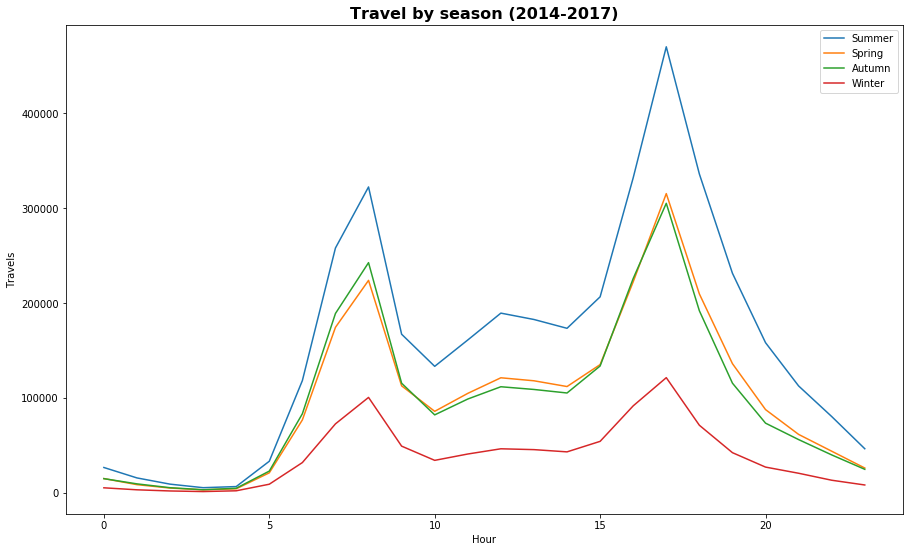

In [15]:
dfagg_clima_verao = dfagg_clima[dfagg_clima.season=='verão']
dfagg_clima_prima = dfagg_clima[dfagg_clima.season=='primavera']
dfagg_clima_out   = dfagg_clima[dfagg_clima.season=='outono']
dfagg_clima_inver = dfagg_clima[dfagg_clima.season=='inverno']

plt.rcParams["figure.figsize"] = (15,9)

plt.plot(dfagg_clima_verao.hour, dfagg_clima_verao.trip_count, label="Summer")
plt.plot(dfagg_clima_prima.hour, dfagg_clima_prima.trip_count, label="Spring")
plt.plot(dfagg_clima_out.hour,dfagg_clima_out.trip_count, label="Autumn")
plt.plot(dfagg_clima_inver.hour,dfagg_clima_inver.trip_count, label="Winter")

# Add legend
plt.legend(loc='upper right')
plt.title("Travel by season (2014-2017)", fontsize=16, fontweight='bold')
plt.xlabel("Hour")
plt.ylabel("Travels")
plt.show()

We can observe that the demand between the seasons of the year Autumn and Spring stays stable while the demand has significant increase and reduction for the summer and the winter.
The usage trend seems to keep the same rhythm between the seasons of the year having the same peaks and reductions throughout the day.

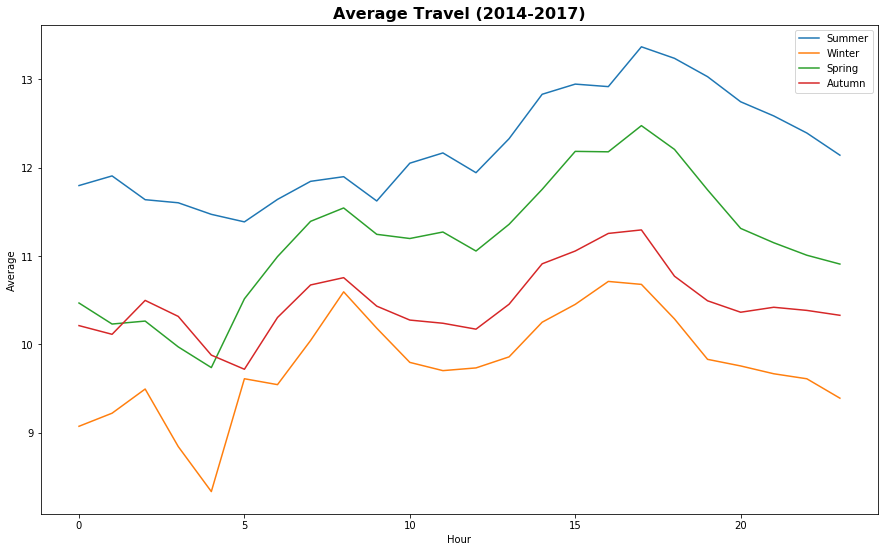

In [16]:
dfagg_clima_verao = dfagg_clima[dfagg_clima.season=='verão']
dfagg_clima_inver = dfagg_clima[dfagg_clima.season=='inverno']
dfagg_clima_prima = dfagg_clima[dfagg_clima.season=='primavera']
dfagg_clima_out   = dfagg_clima[dfagg_clima.season=='outono']

plt.rcParams["figure.figsize"] = (15,9)

plt.plot(dfagg_clima_verao.hour, dfagg_clima_verao.tripduration, label="Summer")
plt.plot(dfagg_clima_inver.hour,dfagg_clima_inver.tripduration, label="Winter")
plt.plot(dfagg_clima_prima.hour, dfagg_clima_prima.tripduration, label="Spring")
plt.plot(dfagg_clima_out.hour,dfagg_clima_out.tripduration, label="Autumn")

# Add legend
plt.legend(loc='upper right')
plt.title("Average Travel (2014-2017)", fontsize=16, fontweight='bold')
plt.xlabel("Hour")
plt.ylabel("Average")
plt.show()

In the duration of travel there does not seem to be a pattern in the behavior, especially in the morning and in the winter where there is a sharp reduction during the dawn.